In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import random
import time
import collections
import warnings
import os

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

from scipy.stats import pearsonr, spearmanr

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ten

In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.5
1.2.1


In [3]:
train_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/tcga_sample_identifiers.tsv', header=0, sep='\t')

In [4]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']

merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])

In [5]:
train_tcga_df['cancer_type'] = merge_train
train_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0,BRCA
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0,LUAD
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0,DLBC
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0,UCEC
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0,SKCM


In [6]:
test_tcga_df['cancer_type'] = merge_test
test_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0,HNSC
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0,CESC
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0,LUSC
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0,LGG
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0,OV


In [7]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, var_layer, mean_layer, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        self.var_layer = var_layer
        self.mean_layer = mean_layer
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + self.var_layer - K.square(self.mean_layer) - 
                                K.exp(self.var_layer), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [8]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [9]:
class Tybalt():
    """
    Facilitates the training and output of tybalt model trained on TCGA RNAseq gene expression data
    """
    def __init__(self, original_dim, hidden_dim, latent_dim,
                 batch_size, epochs, learning_rate, kappa, beta):
        self.original_dim = original_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kappa = kappa
        self.beta = beta

    def build_encoder_layer(self):
        # Input place holder for RNAseq data with specific input size
        self.rnaseq_input = Input(shape=(self.original_dim, ))

        # Input layer is compressed into a mean and log variance vector of size `latent_dim`
        # Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
        # and relu activation) are funneled separately
        # Each vector of length `latent_dim` are connected to the rnaseq input tensor
        hidden_dense_linear = Dense(self.hidden_dim, kernel_initializer='glorot_uniform')(self.rnaseq_input)
        hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
        hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

        z_mean_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
        self.z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

        z_log_var_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
        self.z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

        # return the encoded and randomly sampled z vector
        # Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
        self.z = Lambda(sampling, output_shape=(self.latent_dim, ))([self.z_mean_encoded, self.z_log_var_encoded])
    
    def build_decoder_layer(self):
        # The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
        self.decoder_model = Sequential()
        self.decoder_model.add(Dense(self.hidden_dim, activation='relu', input_dim=self.latent_dim))
        self.decoder_model.add(Dense(self.original_dim, activation='sigmoid'))
        self.rnaseq_reconstruct = self.decoder_model(self.z)
        
    def compile_vae(self):
        adam = optimizers.Adam(lr=self.learning_rate)
        vae_layer = CustomVariationalLayer(self.z_log_var_encoded,
                                           self.z_mean_encoded)([self.rnaseq_input, self.rnaseq_reconstruct])
        self.vae = Model(self.rnaseq_input, vae_layer)
        self.vae.compile(optimizer=adam, loss=None, loss_weights=[self.beta])
        
    def get_summary(self):
        self.vae.summary()
  
    def visualize_architecture(self, output_file):
        # Visualize the connections of the custom VAE model
        plot_model(self.vae, to_file=output_file)
        SVG(model_to_dot(self.vae).create(prog='dot', format='svg'))
        
    def train_vae(self):
        self.hist = self.vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=self.epochs,
               batch_size=self.batch_size,
               validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)),
               callbacks=[WarmUpCallback(self.beta, self.kappa)])
    
    def visualize_training(self, output_file):
        # Visualize training performance
        history_df = pd.DataFrame(self.hist.history)
        ax = history_df.plot()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('VAE Loss')
        fig = ax.get_figure()
        fig.savefig(output_file)
        
    def compress(self, df):
        # Model to compress input
        self.encoder = Model(self.rnaseq_input, self.z_mean_encoded)
        
        # Encode rnaseq into the hidden/latent representation - and save output
        encoded_df = self.encoder.predict_on_batch(df)
        encoded_df = pd.DataFrame(encoded_df, columns=range(1, self.latent_dim + 1),
                                  index=rnaseq_df.index)
        return encoded_df
    
    def get_decoder_weights(self):
        # build a generator that can sample from the learned distribution
        decoder_input = Input(shape=(self.latent_dim, ))  # can generate from any sampled z vector
        _x_decoded_mean = self.decoder_model(decoder_input)
        self.decoder = Model(decoder_input, _x_decoded_mean)
        weights = []
        for layer in self.decoder.layers:
            weights.append(layer.get_weights())
        return(weights)
    
    def predict(self, df):
        return self.decoder.predict(np.array(df))
    
    def save_models(self, encoder_file, decoder_file):
        self.encoder.save(encoder_file)
        self.decoder.save(decoder_file)

In [41]:
# Set common hyper parameters
rnaseq_train_df = train_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)
rnaseq_test_df = test_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)

original_dim = rnaseq_train_df.shape[1]
latent_dim = 100
beta = K.variable(0)
epsilon_std = 1.0

# Model A (100 hidden layer size)
model_a_latent_dim = 100
model_a_batch_size = 100
model_a_epochs = 100
model_a_learning_rate = 0.001
model_a_kappa = 1.0

In [42]:
model_a = Tybalt(original_dim=original_dim,
                 hidden_dim=model_a_latent_dim,
                 latent_dim=latent_dim,
                 batch_size=model_a_batch_size,
                 epochs=model_a_epochs,
                 learning_rate=model_a_learning_rate,
                 kappa=model_a_kappa,
                 beta=beta)

In [43]:
# Compile Model A
model_a.build_encoder_layer()
model_a.build_decoder_layer()
model_a.compile_vae()
model_a.get_summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 16148)         0                                            
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 100)           1614900     input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 100)           400         dense_6[0][0]                    
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 100)           0           batch_normalization_4[0][0]      
___________________________________________________________________________________________

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


In [44]:
model_a.train_vae()

Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 19s - loss: -184127256.0116 - val_loss: -288975562.0687
Epoch 2/100
9954/9954 [==============================] - 19s - loss: -313611034.2262 - val_loss: -311879839.8843
Epoch 3/100
9954/9954 [==============================] - 19s - loss: -314340222.2704 - val_loss: -314460064.6944
Epoch 4/100
9954/9954 [==============================] - 19s - loss: -314359820.1198 - val_loss: -314736265.3165
Epoch 5/100
9954/9954 [==============================] - 19s - loss: -314521814.8700 - val_loss: -314625035.9783
Epoch 6/100
9954/9954 [==============================] - 19s - loss: -314581886.8877 - val_loss: -314801550.2929
Epoch 7/100
9954/9954 [==============================] - 19s - loss: -314557361.4113 - val_loss: -314848673.4467
Epoch 8/100
9954/9954 [==============================] - 19s - loss: -314586555.3257 - val_loss: -314850717.9168
Epoch 9/100
9954/9954 [=========================

9954/9954 [==============================] - 19s - loss: -314687730.7422 - val_loss: -314852524.7884
Epoch 73/100
9954/9954 [==============================] - 19s - loss: -314687690.7631 - val_loss: -314852515.9349
Epoch 74/100
9954/9954 [==============================] - 19s - loss: -314683862.7864 - val_loss: -314852437.8156
Epoch 75/100
9954/9954 [==============================] - 20s - loss: -314683551.2927 - val_loss: -314654526.7848
Epoch 76/100
9954/9954 [==============================] - 19s - loss: -314674888.3134 - val_loss: -314852478.1483
Epoch 77/100
9954/9954 [==============================] - 19s - loss: -314685635.8513 - val_loss: -314852530.0542
Epoch 78/100
9954/9954 [==============================] - 19s - loss: -314687746.7840 - val_loss: -314852524.6148
Epoch 79/100
9954/9954 [==============================] - 19s - loss: -314687747.2727 - val_loss: -314852527.5081
Epoch 80/100
9954/9954 [==============================] - 19s - loss: -314687744.5787 - val_loss: -31

In [45]:
rnaseq_df = pd.concat([rnaseq_train_df, rnaseq_test_df])

model_a_compression = model_a.compress(rnaseq_df)

In [46]:
learning_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/learning.pdf'
compress_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/compress.tsv'
encoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/encoder_twohidden100_vae.hdf5'
decoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/decoder_twohidden100_vae.hdf5'
weight_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/enc_dec_weights.tsv'

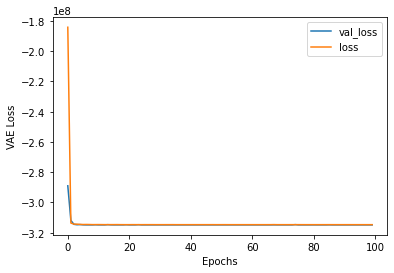

In [47]:
model_a.visualize_training(learning_path)

In [48]:
model_a_weights = model_a.get_decoder_weights()

In [49]:
model_a_compression.to_csv(compress_path, sep='\t', compression='gzip')
model_a.save_models(encoder_path, decoder_path)

In [50]:
def extract_weights(weights, weight_file):
    # Multiply hidden layers together to obtain a single representation of gene weights
    intermediate_weight_df = pd.DataFrame(weights[1][0])
    hidden_weight_df = pd.DataFrame(weights[1][2])
    abstracted_weight_df = intermediate_weight_df.dot(hidden_weight_df)

    abstracted_weight_df.index = range(1, 101)
    abstracted_weight_df.columns = rnaseq_df.columns
    abstracted_weight_df.to_csv(weight_file, sep='\t')

In [51]:
extract_weights(model_a_weights, weight_path)

In [52]:
compress_data = model_a_compression
full_data = rnaseq_df

print(compress_data.shape)
print(full_data.shape)

(11060, 100)
(11060, 16148)


In [57]:
reconstructed_data = pd.DataFrame(model_a.predict(compress_data))

#r = pearsonr([1,2,3], [4,3,2])


r = [pearsonr(reconstructed_data.iloc[x, :], full_data.iloc[x, :])[0] for x in range(full_data.shape[0])]

s = [spearmanr(reconstructed_data.iloc[x, :], full_data.iloc[x, :])[0] for x in range(full_data.shape[0])]


print(np.mean(r))
print(np.mean(s))

0.006710269524288125
0.07239622342418503
